In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
df = pd.read_parquet('../Dataframes/df.parquet.gzip')

In [3]:
data = df

# constants
lookback = 50
test_size = int(.3 * len(data))
batch_size = 512
epoch = 10

input_features = data.iloc[:, [2,3]].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (-1, 1))

input_data[:,0:2] = sc.fit_transform(input_features[:,:])

In [7]:
data.iloc[:, [2,3]].values

array([[1.5829, 1.5761],
       [1.5795, 1.5682],
       [1.5787, 1.5699],
       ...,
       [1.2897, 1.2844],
       [1.2878, 1.2795],
       [   nan,    nan]])

In [4]:
data.head(10)

,date,open,high,low,close,wclose,delta,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
50,13/3/2000,1.5773,1.5829,1.5761,1.5786,1.579050,0.0,34.042553,29.078014,47.368421,...,1.58335,1.57575,1.579550,1.57950,-1051.660517,-480.169784,-124.552390,-374.380286,-405.042029,-553.768912
51,14/3/2000,1.5786,1.5795,1.5682,1.5787,1.576275,0.0,67.307692,63.253012,51.470588,...,1.58120,1.57215,1.576675,1.57385,-418.016850,-528.634361,-464.546547,-528.940484,-418.450089,-548.468327
52,15/3/2000,1.5787,1.5787,1.5699,1.5733,1.573800,0.0,34.693878,32.692308,30.722892,...,1.57910,1.56905,1.574075,1.57430,-422.252011,-497.671324,-568.730181,-608.062000,-416.686639,-543.624365
53,16/3/2000,1.5733,1.5775,1.5692,1.5765,1.574925,0.0,73.451327,56.462585,53.205128,...,1.57810,1.56955,1.573825,1.57335,-986.842105,-527.622595,-562.098501,-598.903980,-423.601117,-539.882002
54,17/3/2000,1.5765,1.5766,1.5702,1.5753,1.574350,0.0,64.210526,62.831858,48.299320,...,1.57705,1.56970,1.573375,1.57340,-945.945946,-1004.566210,-619.904891,-605.513402,-425.768716,-543.211462
55,20/3/2000,1.5753,1.5755,1.5652,1.5688,1.569575,0.0,29.268293,26.666667,25.174825,...,1.57605,1.56770,1.571875,1.57035,-996.677741,-949.796472,-987.099296,-643.718398,-424.939212,-549.650297
56,21/3/2000,1.5688,1.5774,1.5667,1.5700,1.571025,1.0,39.344262,39.024390,35.555556,...,1.57645,1.56595,1.571200,1.57205,439.560440,-272.373541,-819.672131,-668.188839,-493.292128,-549.682804
57,22/3/2000,1.5700,1.5801,1.5620,1.5806,1.575825,1.0,102.762431,102.762431,102.762431,...,1.57875,1.56435,1.571550,1.57105,430.442920,537.261698,519.570488,-731.153695,-593.622772,-558.183297
58,23/3/2000,1.5806,1.5901,1.5755,1.5874,1.585100,1.0,90.391459,90.391459,90.391459,...,1.58510,1.56875,1.576925,1.58280,141.857175,183.609406,224.795834,47.024049,-580.628944,-558.700648
59,24/3/2000,1.5874,1.5959,1.5840,1.5926,1.591275,1.0,90.265487,90.265487,90.265487,...,1.59300,1.57975,1.586375,1.58995,123.669380,146.514411,172.781294,252.413836,-379.571709,-528.186512


In [5]:
X = []
y = []
for i in range(len(data) - lookback - 1):
    t = []
    for j in range(0, lookback):
        t.append(input_data[[(i + j)], :])
    X.append(t)
    y.append(input_data[i + lookback, 1])

In [6]:
X, y = np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0], lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
X.shape

(5079, 50, 2)

In [7]:
file = "./Models/" + "Model" + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    # model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5079/5079 [==============================] - 8s 2ms/step - loss: 0.0123
Epoch 2/5
5079/5079 [==============================] - 7s 1ms/step - loss: 0.0032
Epoch 3/5
5079/5079 [==============================] - 7s 1ms/step - loss: 0.0026
Ep

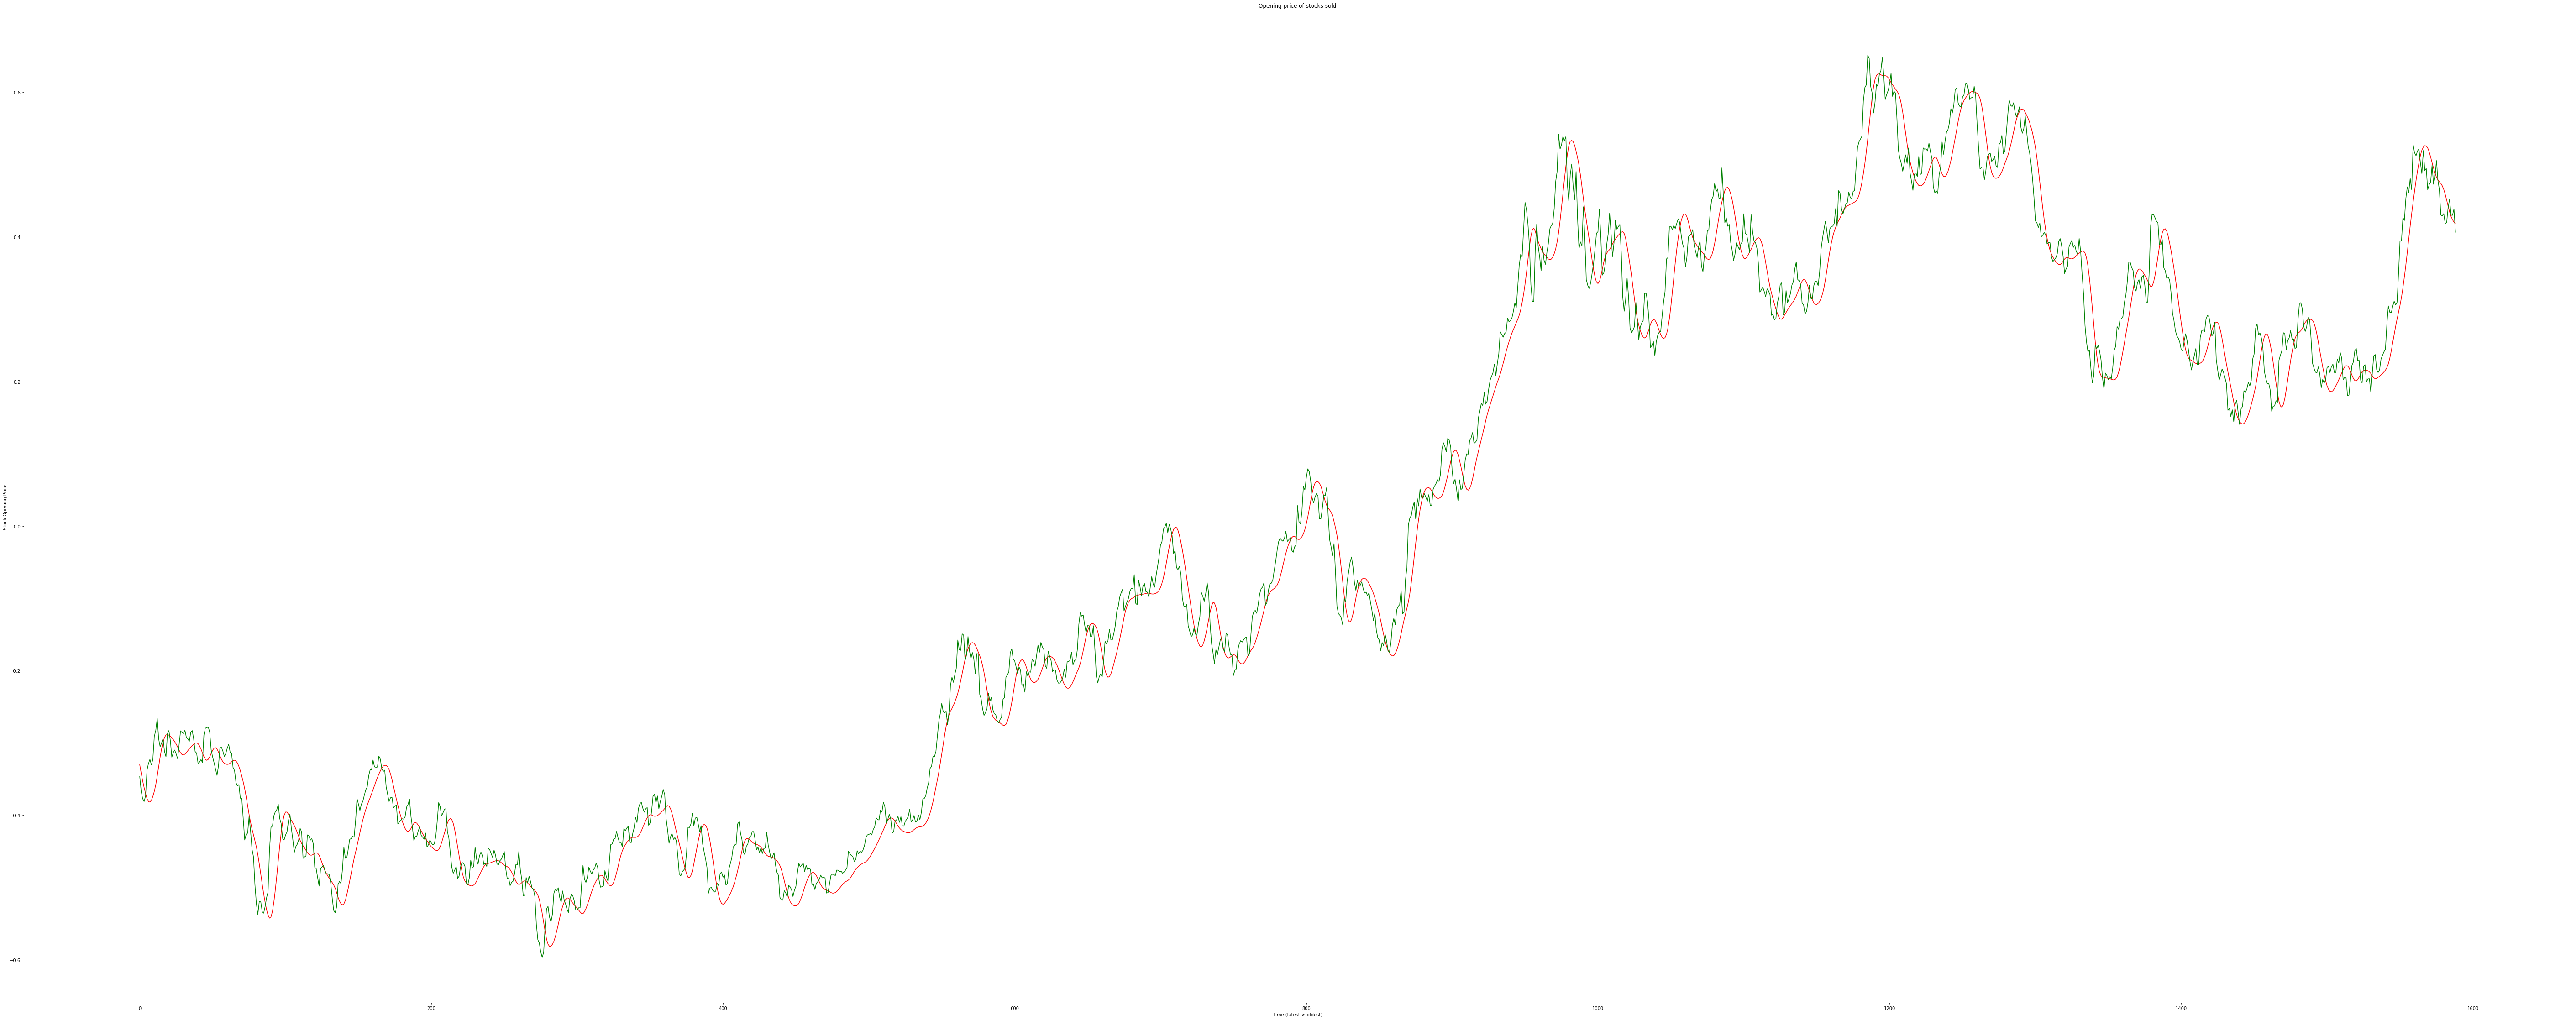

In [8]:
predicted_value= model.predict(X_test)
plt.figure(figsize=(100,40))
plt.plot(predicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

# website link: https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679

In [89]:
input_features = sc.inverse_transform(input_features[lookback:test_size+(2*lookback)])

In [23]:
def getSharpeRatio(): 
    test = data[['open']][lookback:test_size+(2*lookback)]
    test['next'] = test['open'].shift(1)
    test['diff'] = test['next'] - test['open']
    diff = test['diff'].to_numpy()
    diff[0] = 0
    diff = diff.reshape(diff.shape[0],1)

    profit = []

    for i in range(diff.shape[0]):
        profit.append(diff[i][0] * predicted_value[i][0])

    profit = np.array(profit)

    sharpe = np.sqrt(252) * profit.mean() / profit.std()

    return sharpe

In [24]:
getSharpeRatio()

0.3663960109339475